In [4]:
#Преамбула
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.ticker
#from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
#                               AutoMinorLocator)
from scipy.optimize import *
from ipywidgets import interact
from sympy import *
%matplotlib notebook

# Стирлинг на пути к совершенству
В этом блокноте представлена часть обработки данных физического эксперимента, остальную часть можно найти <a href="https://mega.nz/#F!B7B2xQaT!kWrw0UJEBtKHW8B_EbFJJA">на облаке</a>&nbsp;или у&nbsp;<a href="https://vk.com/maxkway">автора</a>

## Описание
Было предложено измерить КПД двигателя Стирлинга и сравнить с оценкой по циклу Карно.
Для этого были использованы: спиртовка, весы, мультиметр, датчик Arduino, цифровой осцилограф а так же манометр дифферинциальный, резистор и реостат.
### Ход работы
* Измерение скорости выгорания спиртовки
* Калибровка дифферинциального цифрового датчика давления по обычному
* Сборка устновки и цепи нагрузки
* Запуск эксперимента, в ходе которого с помощью реостата была найдена максимальная рабочая мощность



Из построения и анализа в Exel'е была выяснена следующая зависимость давления(сверх атмосферы) от времени:
\begin{equation}\label{eq:p}
P(t) = a\cdot \cos{ (\omega t + \varphi)},
\end{equation}
причём $a = 0.17 \, bar$, $\omega = 134.2\,c^-$, $\varphi = -4.8$

In [10]:
#объявление констант
p_0 = 1 # среднее даление
p_a = 0.1735 # амплитуда колебаний давления
w = 134.25609630 # частота работы двигателя Стирлинга
T = 2*np.pi/134.25609630 ## Период функции
v_0  = 10.8875035 # средний рабочий объём, в см куб
v_a = 3.1573 # амплитуда объёма
phi = 134.25609630*0.0357 - 2*np.pi # начальная фаза давления
dphi = 134.25609630*0.0006 # разность фаз между давлением и объёмом
g = 1.4 # показатель адиабаты сухого воздуха
c = 1/(g-1) # теплоёмкость воздуха
c_p = c + 1

#### Обработка данных по давлению

In [6]:
## извлечение данных из файла
data_0 = np.loadtxt(r"C:\Users\maxkway\Desktop\Labaratory\Stirling\pressure.txt", skiprows=2)

In [7]:
p = data_0[::, 0:2].tolist()
p = [p[i] for i in range(len(p)-1) if (p[i][1] != p[i+1][1]) & (p[i][1] > 0.01)] # удаление шума
p = np.transpose(np.array(p))

In [8]:
# полученная зависимость
x = np.linspace(0, 0.25, 5000)
z = 0.1735*np.cos(134.25609630*(x - 0.0357))

<IPython.core.display.Javascript object>


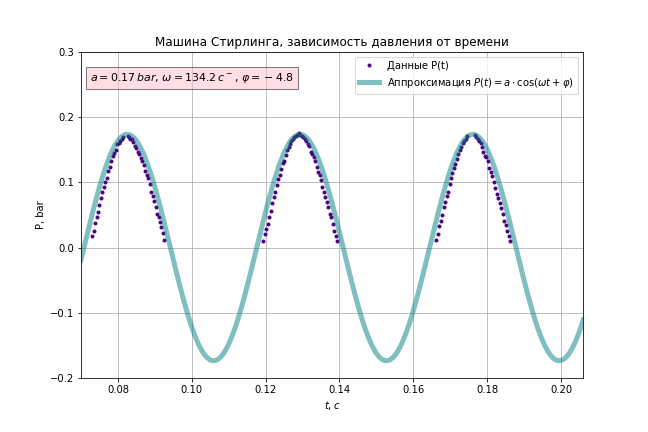

In [368]:
%matplotlib notebook

fig, ax = plt.subplots()

ax.plot(p[0]*(2e-4),p[1],".", color = 'indigo', label = 'Данные P(t)')
ax.plot(x, z, linestyle = "-", color = 'teal', alpha = 0.5, lw = 5, 
        label = r'Аппроксимация $P(t) = a\cdot \cos{ (\omega t + \varphi)}$')


plt.title('Машина Стирлинга, зависимость давления от времени')
plt.ylabel(r'P, bar')
plt.xlabel(r'$t, c$')

ax.set_xlim([0.07, 0.206])
ax.set_ylim([-0.2, 0.3])

ax.grid()


# Текст в рамке

plt.text(0.1, 0.26, r'$a = 0.17 \, bar$, $\omega = 134.2\,c^-$, $\varphi = -4.8$', fontsize=11,
         # выравнивание по вертикали и по горизонтали по центру
         horizontalalignment='center', verticalalignment='center',
         bbox=dict(facecolor='pink', alpha=0.5))

plt.legend(loc='upper right')
fig.set_size_inches(9, 6)
fig.savefig('pressure_main.pdf', dpi=400)
fig.savefig('pressure_main.png', dpi=400)

#### Обработка данных по объёму сосуда

In [9]:
#извлечение данных для исследования объёма
v = np.transpose(np.loadtxt(r"C:\Users\maxkway\Desktop\Labaratory\Stirling\volume.txt", skiprows=2))
z_v = -5*np.cos(134.25609630*(x - 0.0357-0.0006))

<IPython.core.display.Javascript object>


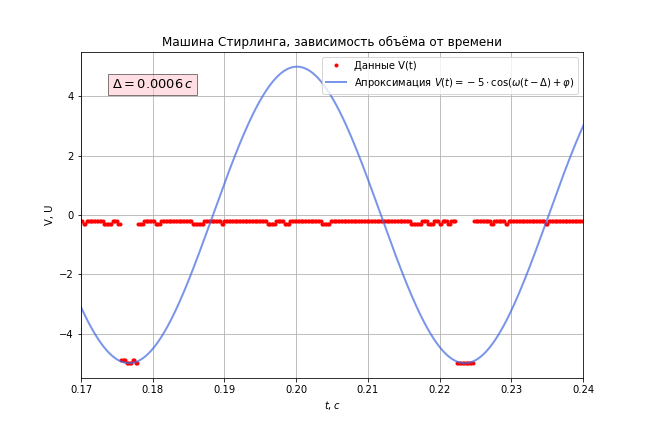

In [372]:
%matplotlib notebook

fig, ax = plt.subplots()

ax.plot(v[0]*(2e-4),v[1]/10-5,".", color = 'red', label = 'Данные V(t)')
ax.plot(x, z_v, linestyle = "-", color = 'royalblue', alpha = 0.7, lw = 2, 
        label = r'Апроксимация $V(t) = -5\cdot \cos{ (\omega (t-\Delta) + \varphi)}$')

plt.title('Машина Стирлинга, зависимость объёма от времени')
plt.ylabel(r'V, U')
plt.xlabel(r'$t, c$')

ax.set_xlim([0.17, 0.24])
#ax.set_ylim([-6, 3])

ax.grid()


# Текст в рамке
plt.text(0.18, 4.4, r'$\Delta = 0.0006\,c$', fontsize=13,
         # выравнивание по вертикали и по горизонтали по центру
         horizontalalignment='center', verticalalignment='center',
         bbox=dict(facecolor='pink', alpha=0.5))


plt.legend(loc='upper right')
fig.set_size_inches(9, 6)
fig.savefig('volume_t.pdf', dpi=400)
fig.savefig('volume_t.png', dpi=400)

### Построение PV диаграммы

In [19]:
## данные для построения графика PV
tau = np.linspace(0, T,5000)
p_real = 1 + 0.1735*np.cos(134.25609630*(tau - 0.0357))
v_real = 10.8875035 - 3.1573*np.cos(134.25609630*(tau - 0.0357-0.0006))
dv = np.max(v_real) - np.min(v_real)
v_out = np.linspace(np.min(v_real)-dv/3, np.max(v_real)+dv/3, 7000)

temp = p_real*v_real # температура в терминах pv
entropi = p_real*v_real**(1.4) # адиабаты
print(min(temp), max(temp), min(entropi), max(entropi))

9.064582631505488 11.676860382899449 20.54327215431622 33.46834737156088


<IPython.core.display.Javascript object>


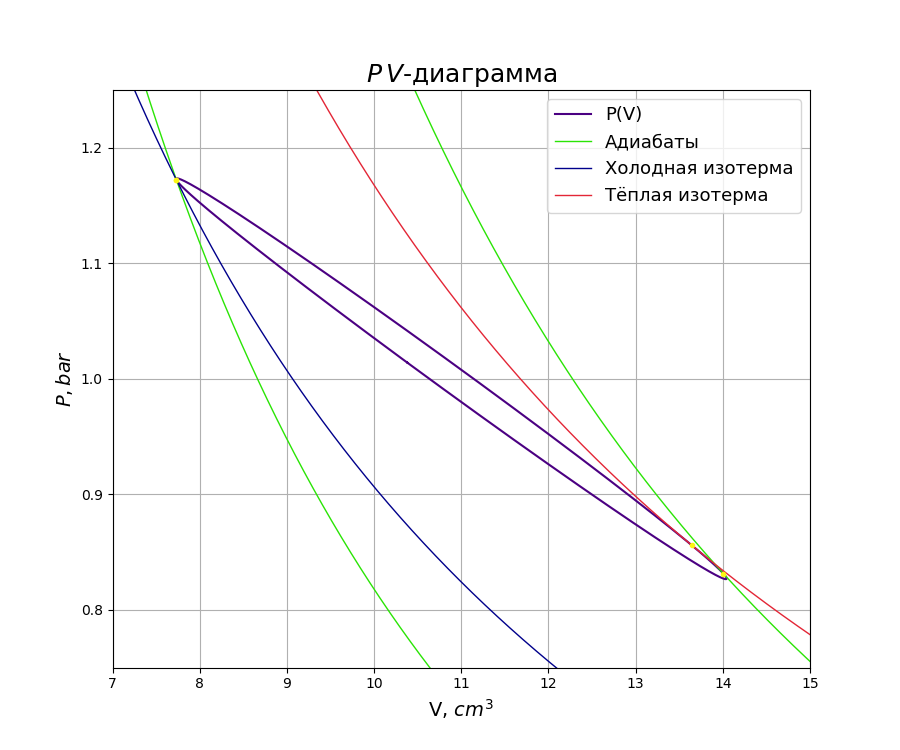

In [21]:
# построение PV и касательных изотерм, адиабат
%matplotlib notebook
fig, ax = plt.subplots()

s_max = max(entropi) * v_out**(-g) # 1.4 - показатель адиабаты для сухого воздуха
s_min = min(entropi) * v_out**(-g)

t_min = min(temp) / v_out
t_max = max(temp) / v_out

ax.plot(v_real, p_real ,"-", color = 'indigo', label = 'P(V)', lw=1.5)

ax.plot(v_out, s_max ,"-", color = '#2ae405', label = 'Адиабаты', lw=1)
ax.plot(v_out, s_min ,"-", color = '#2ae405', lw=1)

ax.plot(v_out, t_min ,"-", color = '#00008b', lw=1, label='Холодная изотерма')
ax.plot(v_out, t_max ,"-", color = '#e32636', lw=1, label='Тёплая изотерма')

ax.plot([v_real[np.argmax(entropi)], v_real[np.argmin(entropi)], v_real[np.argmax(temp)], v_real[np.argmin(temp)]] , 
        [p_real[np.argmax(entropi)], p_real[np.argmin(entropi)], p_real[np.argmax(temp)], p_real[np.argmin(temp)]] ,
        ".", color = '#faf614', lw=9) # - точки касания

plt.title('$P\,V$-диаграмма', fontsize=18)
plt.xlabel(r'V, $cm^3$', fontsize=14)
plt.ylabel(r'$P, bar$', fontsize=14)

ax.set_xlim([7, 15])
ax.set_ylim([0.75, 1.25])

ax.grid()

plt.legend(loc='upper right',fontsize=13)
fig.set_size_inches(9, 7.5)
fig.savefig('PV.pdf', dpi=400)
fig.savefig('PV.png', dpi=400)

### Расчёт КПД
Сноска: Оказалось у нас кривая параметризация (время при развёртке текло не в ту сторону), поэтому в формулах всюду t заменено на -t.

На данном этапе имеем следующие зависимости P(t):
$$
P(t) = P_0 + P_a\cdot \cos{ (-\omega\,t + \varphi)},
$$
$$
V(t) = V_0 - V_a \cdot \cos{ (\omega\,(-t-\Delta) + \varphi)}
$$
Для вычисления КПД необходимо подсчитать  подведённое тепло
$$
\delta Q^+ = \delta U + \delta A,
$$
где приращение необходимо рассчитать между крайними адиабатами, точки пересечения с которыми задаются как
\begin{align}
t_1 = argmin(P\cdot V^{\gamma}(t)),\\
t_2 = argmax(P\cdot V^{\gamma}(t))
\end{align}
Тогда работа 
$$
\delta A = \int_{V(t_1)}^{V(t_2)} P \text{ d}V = \int_{t_1}^{t_2} P\left(\frac{\text{d}V}{\text{d}t}\right)\, dt\,
$$
а $$\delta U = c_v \delta(PV(t))= c_v [PV(t_2) - PV(t_1)],$$
считая $с_v$ постоянной и равной $ \dfrac{1}{\gamma-1}$.

Простейшее интегрирование же для всего контура даёт:
$$
\delta A_{full}= P_a V_a \frac{\omega T}{2}\, \sin{\delta \phi},
$$ где $\delta \phi$ - разность фаз между давлением и объёмом$$.

Отсюда легко находится
$$
\eta = \frac{\delta A_{full}}{\delta Q^+}
$$

In [353]:
#from sympy import *
# Объявление символьных функций
t = var('t')
p_t = p_0 + p_a * cos(-w * t - phi )
v_t = v_0 - v_a * cos(-w * t - phi - dphi)
U = c*p_t*v_t # внутренняя энергия газа
po = p_t * diff(v_t, t) # мощность
s  = p_t * v_t**g # изоэнтропы локальные

In [350]:
# Поиск точек касания адиабат и PV -диаграммы
from scipy.optimize import minimize
res_min = minimize(lambda x: s.subs(t, x), 0, method='nelder-mead',
    options={'xtol': 1e-8, 'disp': True})
res_max = minimize(lambda x: -s.subs(t, x), 0.03, method='nelder-mead',
    options={'xtol': 1e-8, 'disp': True})
t_1 = res_min.x;t_2 = res_max.x
print(t_1, t_2)

Optimization terminated successfully.
         Current function value: 20.543272
         Iterations: 25
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: -33.468347
         Iterations: 20
         Function evaluations: 40
[0.01029099] [0.03274607]


<IPython.core.display.Javascript object>


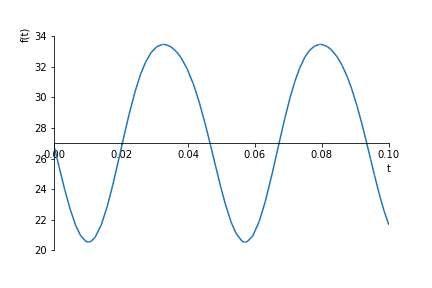

In [352]:
# визуальная проверка на корректность
from sympy.plotting import plot
s1 = plot(s,(t, 0, 0.1))

In [379]:
#Подсчёт работы и внутренней энергии
A_12 = integrate(po, (t, t_1, t_2))
dU = U.subs(t, t_2) - U.subs(t, t_1)
Q = dU + A_12
# вся работа за цикл
A_full = integrate(po, (t, 0, T))
#кпд
n = A_full/Q # Кпд по циклу
power = A_full/T # мощность
n_c = 1 - min(temp)/max(temp) # - Карно на тех же изотермах
print(n, n_c, power)


0.0108200691481846 0.22371405204258454 2.95893095109369


### Результаты
* Построена PV диаграмма
* Найдено КПД $$\eta = 1 \%$$ И КПД Карно $$\eta_{max} = 22 \% $$
* Найдена мощность $$P_h = 3\,bar\cdot cm^3/c = 0.3\, Вт$$

Теперь, зная среднюю мощность на нагрузке $P_r = 0.0037$ Вт, можно оценить коэффициент преобразования механческой энергии в электрическую
$$
\mu = \frac{P_r}{P_h}\cdot 100 \% = 1\%
$$

<h1 style="font-style:italic"><span style="font-family:Comic Sans MS,cursive"><span style="color:#27ae60">This is the end..</span></span></h1>
<p><img alt="" src="https://psv4.userapi.com/c848336/u145463530/docs/d5/b24a7b577175/heh.png" style="height:500px; width:750px" /></p>


In [18]:
%matplotlib inline
@interact
def f(c: (0, 50)):
    fig, ax = plt.subplots()
    s = c * v_out**(-1.4) # 1.4 - показатель адиабаты для сухого воздуха
    ax.plot(v_real, p_real ,"-", color = 'indigo', label = 'P(V)')
    ax.plot(v_out, s ,"-", color = 'red', label = 'Адиабата')
    
    plt.title('PV-диаграмма')
    plt.xlabel(r'V, $cm^3$')
    plt.ylabel(r'$P, bar$')
    
    #ax.set_xlim([0.17, 0.24])
    #ax.set_ylim([-6, 3])
    
    ax.grid()

    plt.legend(loc='upper right')
    #fig.set_size_inches(9, 6)
    #ig.savefig('volume_t.pdf', dpi=400)
    #fig.savefig('PV.png', dpi=400)

interactive(children=(IntSlider(value=25, description='c', max=50), Output()), _dom_classes=('widget-interact'…

In [12]:
## данные для построения графика TS
tau = np.linspace(0, T,5000)
p_real = 1 + 0.1735*np.cos(134.25609630*(tau - 0.0357))
v_real = 10.8875035 - 3.1573*np.cos(134.25609630*(tau - 0.0357-0.0006))
dv = np.max(v_real) - np.min(v_real)
v_out = np.linspace(np.min(v_real)-dv/3, np.max(v_real)+dv/3, 7000)
temp = p_real*v_real # температура в терминах pv
entro = c * np.log(p_real) + c_p * np.log(v_real) # Энтропия


<IPython.core.display.Javascript object>


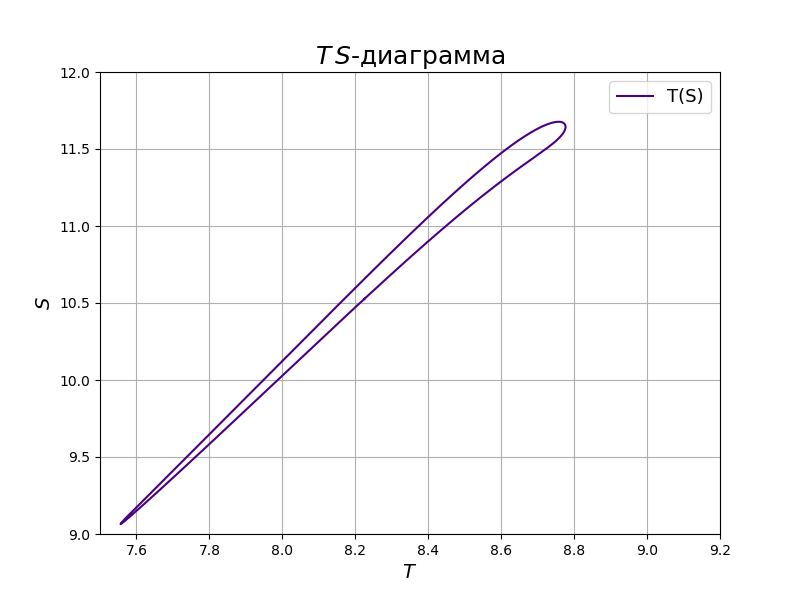

In [17]:
# построение TS 
%matplotlib notebook
fig, ax = plt.subplots()


ax.plot(entro, temp ,"-", color = 'indigo', label = 'T(S)', lw=1.5)



plt.title('$T\,S$-диаграмма', fontsize=18)
plt.xlabel(r'$T$', fontsize=14)
plt.ylabel(r'$S$', fontsize=14)

ax.set_xlim([7.5, 9.2])
ax.set_ylim([9, 12])

ax.grid()

plt.legend(loc='upper right',fontsize=13)
fig.set_size_inches(8, 6)
fig.savefig('TS.pdf', dpi=400)
fig.savefig('TS.png', dpi=400)